### Inputs:

- **Dictionary of XRD Diffraction pattern and Chemical Information**:
  - Should be saved in a directory in ~/cdvae/data/ as a dictionary with a unique ID for each pattern and the value being a tuple of the pattern stored as a pytorch tensor and a list of elements in the material. 
  - Make sure that the list of elements meets the following requirements: 
    - Elements should be ints corresponding to the atomic numbers
    - We do not currently support forcing the exact stoichiometry in this tutorial, but we plan to add this feature in the future.
  - Make sure that the diffraction pattern meets the following requirements:
    - Range: 5 to 90 degrees
    - Increment: 0.01 degrees
    - Total length: 8500 points
    - If not available, interpolate the data over the range where data was collected, setting other values to 0. Built-in preprocessing support for this method is forthcoming. For now, we have a brief tutorial on how to convert a csv file with this specific range to a pytorch tensor and create the dictionary that is needed for the rest of the tutorial

NOTE: 
- Normalize your XRDs by the maximum magnitude!
- Set your tensor type to FloatTensor!

# Brief tutorial on how to go from csv -> pytorch tensor

In [1]:
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys 
sys.path.append("../../")

from cdvae.common.inference_utils import create_inference_dataframe, create_inference_xrd_data, create_inference_graph_data, load_and_modify_config

In [2]:
PbS_xrd = pd.read_csv("Galena_xrd_data.csv", header=None)

In [3]:
PbS_xrd[1] = PbS_xrd[1]/max(PbS_xrd[1])

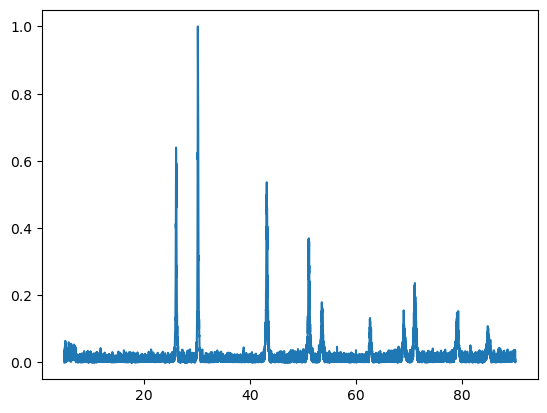

In [4]:
plt.plot(PbS_xrd[0], PbS_xrd[1])

In [5]:
elements_involved = [82, 16]
xrd = torch.tensor(PbS_xrd[1])
xrd = xrd.type(torch.FloatTensor) 
unique_key = "unique_key"

inference_data = {unique_key: (xrd, elements_involved)}
inference_data

{'unique_key': (tensor([0.0000, 0.0012, 0.0238,  ..., 0.0002, 0.0098, 0.0028]),
  [82, 16])}

In [7]:
inference_data_folder_name = "demo"
inference_data_filename = 'raw_xrd_dict.pt'

### CHANGE THESE FOR YOUR OWN SYSTEM 
conf_folder_path = '/home/gridsan/tmackey/Crystalyze/conf/data'
data_folder_path = '/home/gridsan/tmackey/Crystalyze/data/'
scripts_folder_path = '/home/gridsan/tmackey/Crystalyze/scripts/'
inference_data_dir = os.path.join(data_folder_path, inference_data_folder_name) + '/'
os.mkdir(inference_data_dir)

torch.save(inference_data, os.path.join(inference_data_dir + inference_data_filename))

# Begin Inference! Load in data 

In [8]:
inference_data_folder_name = "demo"
inference_data_filename = 'raw_xrd_dict.pt'

### CHANGE THESE FOR YOUR OWN SYSTEM 
conf_folder_path = '/home/gridsan/tmackey/Crystalyze/conf/data'
data_folder_path = '/home/gridsan/tmackey/Crystalyze/data/'
scripts_folder_path = '/home/gridsan/tmackey/Crystalyze/scripts/'

inference_data_dir = os.path.join(data_folder_path, inference_data_folder_name) + '/'

inference_data = torch.load(os.path.join(inference_data_dir + inference_data_filename))

In [9]:
inference_df = create_inference_dataframe(inference_data)
inference_xrd = create_inference_xrd_data(inference_data)
inference_graphs = create_inference_graph_data(inference_data)

In [10]:
#save inference dataframe to the data directory as test.csv
inference_df.to_csv(os.path.join(inference_data_dir, 'test.csv'), index=False)

#save the xrd data to the data directory as test_pv_xrd.pt
torch.save(inference_xrd, os.path.join(inference_data_dir, 'test_pv_xrd.pt'))

#save the dummy graph data to the data directory as test.pt
torch.save(inference_graphs, os.path.join(inference_data_dir, 'test.pt'))

# create a conf file for our new data 

In [11]:
data_yaml = load_and_modify_config('demo')

#save data_yaml
with open(os.path.join(conf_folder_path, 'demo.yaml'), 'w') as f:
    f.write(data_yaml)

# run inference on the data 

In [12]:
def run_evaluation_script(model_path, number_of_attempts, force_num_atoms_flag, force_atom_types_flag, label):
    """
    Construct and execute the evaluation script command based on provided flags.

    Args:
        model_path (str): The path to the model.
        number_of_attempts (int): Number of attempts.
        force_num_atoms_flag (bool): Flag to force the number of atoms.
        force_atom_types_flag (bool): Flag to force the atom types.
        label (str): Label for the evaluation.
    """
    # Base command
    evaluate_file_path = os.path.join(scripts_folder_path, 'evaluate.py')

    for i in range(number_of_attempts):
        command = f"python {evaluate_file_path} --model_path {model_path} --tasks recon --num_batches {number_of_attempts}  --test_set_override {label} --label {label}"

        # Modify command based on flags
        if force_num_atoms_flag:
            command += " --force_num_atoms"
        if force_atom_types_flag:
            command += " --force_atom_types"

        # Print the command to be executed
        print(f"Executing command: {command}")

        # Execute the command
        os.system(command)


In [ ]:
# Example usage
model_path = '/home/gridsan/tmackey/model_folder' # this should be the folder containing the model checkpoint and hyperparameters
label = 'demo'
number_of_attempts = 10
force_num_atoms_flag = True
force_atom_types_flag = True

run_evaluation_script(model_path, number_of_attempts, force_num_atoms_flag, force_atom_types_flag, label)

Executing command: python /home/gridsan/tmackey/Crystalyze/scripts/evaluate.py --model_path /home/gridsan/tmackey/model_folder --tasks recon --num_batches 10  --test_set_override demo --label demo --force_num_atoms --force_atom_types


/home/gridsan/tmackey/.conda/envs/cdvae/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


Data configuration overridden with demo
not using weight initialization
the noise_sd is: 0
not using weight initialization
the noise_sd is: -1
using existing csv file  /home/gridsan/tmackey/Crystalyze/data/demo/test.csv
using existing graph file  /home/gridsan/tmackey/Crystalyze/data/demo/test.pt
using 1 rows given a train_fraction of 1
time taken: 0.0815742015838623
CrystDataModule(self.datasets={'test': [{'_target_': 'cdvae.pl_data.dataset.CrystDataset', 'graph_method': 'crystalnn', 'lattice_scale_method': 'scale_length', 'name': 'Formation energy test', 'niggli': True, 'path': '/home/gridsan/tmackey/Crystalyze/data/demo/test.csv', 'preprocess_workers': 30, 'primitive': False, 'prop': 'spacegroup.number'}], 'train': {'_target_': 'cdvae.pl_data.dataset.CrystDataset', 'graph_method': 'crystalnn', 'lattice_scale_method': 'scale_length', 'name': 'Formation energy train', 'niggli': True, 'path': '/home/gridsan/tmackey/Crystalyze/data/demo/train.csv', 'preprocess_workers': 30, 'primitive':

/home/gridsan/tmackey/.conda/envs/cdvae/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


batch 0 in 1
using psuedo voigt
using gt_num_atoms
using gt_atom_types


/home/gridsan/tmackey/cdvae/cdvae/common/data_utils.py:627: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
100%|██████████| 50/50 [30:25<00:00, 36.51s/it]


Executing command: python /home/gridsan/tmackey/Crystalyze/scripts/evaluate.py --model_path /home/gridsan/tmackey/model_folder --tasks recon --num_batches 10  --test_set_override demo --label demo --force_num_atoms --force_atom_types


In [58]:
#load in model_path / eval_recon_demo.pt
for i in range(5):
    result_data = torch.load(os.path.join(model_path, f"eval_recon_demo_{i}.pt"))
    print(result_data)

{'eval_setting': Namespace(batch_size=500, disable_bar=False, down_sample_traj_step=10, force_atom_types=True, force_num_atoms=True, iteration=0, label='demo', min_sigma=0, model_path='/home/gridsan/tmackey/model_folder', n_step_each=100, num_batches=10, num_batches_to_samples=20, num_evals=1, save_traj=False, start_from='data', step_lr=0.0001, tasks=['recon'], test_set_override='demo'), 'input_data_batch': Batch(edge_index=[2, 16], y=[1, 1], frac_coords=[2, 3], atom_types=[2], lengths=[1, 3], angles=[1, 3], to_jimages=[16, 3], num_atoms=[1], num_bonds=[1], num_nodes=2, batch=[2], ptr=[2]), 'frac_coords': tensor([[[0.7855, 0.1706, 0.8207],
         [0.7945, 0.6724, 0.3228]]]), 'num_atoms': tensor([[2]]), 'atom_types': tensor([[82, 16]]), 'lengths': tensor([[[3.4600, 3.6938, 5.0651]]]), 'angles': tensor([[[82.4289, 86.3507, 88.5487]]]), 'predicted_property': tensor([[0.]]), 'all_frac_coords_stack': [], 'all_atom_types_stack': [], 'time': 86.75326418876648}
{'eval_setting': Namespace(bat

In [65]:
# get the ground truth structure 
ground_truth = torch.load("/home/gridsan/tmackey/cdvae/data/RRUFF_data_test_only_using_amcsd/test.pt")

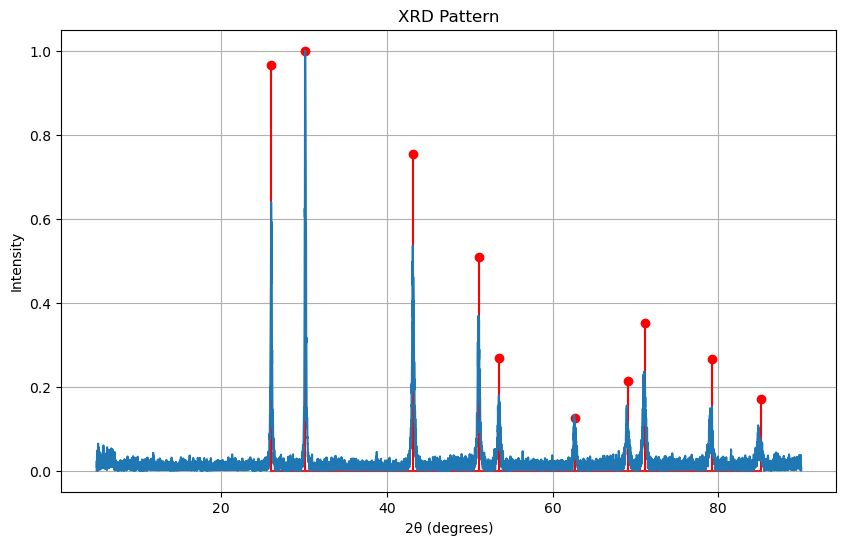

In [74]:
from pymatgen.core import Structure, Lattice
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import matplotlib.pyplot as plt

# Provided crystal data
coordinates, atomic_numbers, lattice_parameters, angles, _, _, _ = ground_truth['Galena']
# Create the lattice
lattice = Lattice.from_parameters(*lattice_parameters, *angles)

# Create the structure
structure = Structure(lattice, atomic_numbers, coordinates)

# Initialize the XRD calculator
xrd_calculator = XRDCalculator()

# Generate the XRD pattern
xrd_pattern = xrd_calculator.get_pattern(structure)

# Plot the XRD pattern
plt.figure(figsize=(10, 6))
plt.stem(xrd_pattern.x, xrd_pattern.y / 100, 'r-')
plt.plot(PbS_xrd[0], PbS_xrd[1])
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity')

plt.title('XRD Pattern')

plt.grid(True)
plt.show()
